<a href="https://colab.research.google.com/github/KuanChihLee/Supervised-Learning/blob/master/Assignment3_Q5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
import math
import pandas as pd
import random

## This assignment section implements logistic classification model and visualized results.

Functions defined

In [0]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def cost(X_train, y_train, weights):
    error = sigmoid(X_train.dot(weights)) - y_train
    cost = sum(abs(error))
    
    return cost 


def batch_gradient_descent(X_train, y_train, weights):
    error = sigmoid(X_train.dot(weights)) - y_train
    grad = np.round(X_train.T.dot(error), 10)

    return grad / X_train.shape[0]


def stochastic_gradient_descent(X_train, y_train, weights):
    index = random.randint(0, X_train.shape[0]-1)
    x = X_train[index]
    y = y_train[index] 
    error = sigmoid(x[np.newaxis, :].dot(weights)) - y
    grad = np.round(x*error, 10)

    return grad


def logistic(dataset, cutoff, iteration, learning_rate, gd='bgd', plot=True):
    N, P = dataset.shape
    # dataset includes label column, therefore, we substract 1
    weights = np.zeros(P-1)
    iter_max = iteration
    lr = learning_rate
    costs = []
    
    df_train = pd.DataFrame(np.zeros((SampleNum,1)), columns=["Category"])
    df_train["Category"][dataset.labels<cutoff] = 0
    df_train["Category"][dataset.labels>=cutoff] = 1
    X_train = dataset.drop('labels', axis=1).values
    y_train = df_train.Category.values
    
    for iiter in range(iter_max):
        if gd == 'sgd':
            grad= stochastic_gradient_descent(X_train, y_train, weights)
        else:
            grad= batch_gradient_descent(X_train, y_train, weights)
        weights -=  lr * grad
        current_cost = cost(X_train, y_train, weights)
        costs.append(current_cost)
        #print("Current cost:", current_cost)
    if plot == True:
        plt.plot(range(iter_max), costs)
        plt.title("Total cost")
        plt.xlabel("Iteration Times")
        plt.ylabel("Error")
        plt.show()
    return weights


def model_predict(dataset, weights, cutoff=0.5, plot_name="default"):
    test_model = dataset.copy()
    test_model["Category"] = dataset.labels.values
    test_model["Category"][dataset.labels<cutoff] = 0
    test_model["Category"][dataset.labels>=cutoff] = 1
    
    idx = 0
    count = 0
    for value in test_model.loc[:,:"Feature_2"].values:
        if test_model.Category[idx] == 0 and weights.dot(value[:, np.newaxis]) >= -np.log(1/cutoff-1):
            count += 1
        elif test_model.Category[idx] == 1 and weights.dot(value[:, np.newaxis]) < -np.log(1/cutoff-1):
            count += 1
        idx += 1
    #print("Error Classification Number: ", count)
    
    if plot_name != 'default':
        fig = plt.figure()
        ax1 = fig.add_subplot(111)
        ax1.scatter(test_model.Feature_1[test_model.Category==0], 
                    test_model.Feature_2[test_model.Category==0], s=15, c='k', marker='o', label=('y<'+str(cutoff)))
        ax1.scatter(test_model.Feature_1[test_model.Category==1], 
                    test_model.Feature_2[test_model.Category==1], s=15, c='r', marker='x', label=('y>'+str(cutoff)))

        line = np.linspace(-1.0, 4.0)
        alpha, beta = -weights[1]/weights[2], -(weights[0]+np.log(1/cutoff-1))/weights[2]
        alpha_des, beta_des = -1, -(-3+np.log(1/cutoff-1))
        ax1.plot(line, alpha * line + beta, 'b-')
        ax1.plot(line, alpha_des * line + beta_des, 'r--')
        ax1.set_xlabel("X1")
        ax1.set_ylabel("X2")
        ax1.set_title(plot_name)
        plt.legend(loc='upper right');
        plt.show()
    
    return count
    
    
def Create_dataset(NumberOfPredictor, Coefficients, SampleNum, Method='Normal', *argv):
    dataset = pd.DataFrame({'Inter': np.ones(SampleNum)})
    for degree in range(NumberOfPredictor):
        name = "Feature_" + str(degree+1)
        if Method == 'Uniform':
            dataset[name] = np.random.uniform(0, 3.0, SampleNum)
        elif Method == 'Normal':
            dataset[name] = np.random.normal(0, 2.0, SampleNum)
        else:
            dataset[name] = np.random.normal(float(argv[0+degree*2]), float(argv[1+degree*2]), SampleNum)
    
    dataset["labels"] = sigmoid(dataset.loc[:, :("Feature_"+str(NumberOfPredictor))].dot(Coefficients))
    return dataset

In [0]:
def LDA_classifier(mean_vectors, cov_matrix, dataset, cutoff=0.5, plot_name='default'): 
    test_model = dataset.copy()
    test_model["Category"] = test_model.labels.values
    test_model["Category"][test_model.labels<cutoff] = 0
    test_model["Category"][test_model.labels>=cutoff] = 1
    
    clas0_num = len(test_model.Category[test_model.Category==0])
    clas1_num = len(test_model.Category[test_model.Category==1])
    prior_clas0 = clas0_num / SampleNum
    prior_clas1 = clas1_num / SampleNum

    ## Important: (x+mean).T Cov(x) (x-mean) -> only in Cov(x) without consideration of class K
    a0 = -np.dot((mean_vectors[1] + mean_vectors[0]).T, 
                 np.linalg.inv(cov_matrix)).dot((mean_vectors[1] - mean_vectors[0])) / 2 + np.log(prior_clas1
                                                                                                  /prior_clas0)
    a1 = np.linalg.inv(cov_matrix).dot(mean_vectors[1] - mean_vectors[0])
    #print(a0)
    #print(a1)
    pred_labels = []
    X_features = test_model.loc[:,'Feature_1':'Feature_2'].values
    predicted_values = a0 + X_features.dot(a1)
    test_model["LDA_solu"] = [1 if pre_value >= 0 else 0 for pre_value in predicted_values]       

    error_classified_num = np.count_nonzero(test_model.LDA_solu.values-test_model.Category.values)
    #print("Error Rate: %s / %s" %(error_classified_num, SampleNum))
    
    if plot_name != 'default':
        fig = plt.figure()
        ax1 = fig.add_subplot(111)
        ax1.scatter(test_model.Feature_1[test_model.Category==0], 
                    test_model.Feature_2[test_model.Category==0], s=15, c='k', marker='o', label='y=0')
        ax1.scatter(test_model.Feature_1[test_model.Category==1], 
                    test_model.Feature_2[test_model.Category==1], s=15, c='r', marker='x', label='y=1')

        line = np.linspace(-1.0, 3.0)
        alpha_des, beta_des = -1, -(-3+np.log(1/cutoff-1))
        ax1.plot(line, alpha_des * line + beta_des, 'r--')
        ax1.plot(line, -a1[0]/a1[1] * line - a0/a1[1], 'b-')
        ax1.set_xlabel("X1")
        ax1.set_ylabel("X2")
        ax1.set_title(plot_name)
        plt.legend(loc='upper left');
        plt.show()
        
    return error_classified_num

In [0]:
def Fisher_LDA(X_data, label_data):
    mean_vectors = []
    ## Mean Vector
    for clas in range(0,class_num):
        mean_vectors.append(np.mean(X_data[label_data==clas], axis=0))
        #print('Mean Vector class %s: %s\n' %(clas, mean_vectors[clas]))

    ## Within-class scatter matrix SW
    S_W = np.zeros((NumberOfPredictor,NumberOfPredictor))
    for clas,mv in zip(range(0,class_num), mean_vectors):
        class_sc_mat = np.zeros((NumberOfPredictor,NumberOfPredictor))      # scatter matrix for every class
        for row in X_data[label_data == clas]:
            row, mv = row.reshape(NumberOfPredictor,1), mv.reshape(NumberOfPredictor,1) # make column vectors
            class_sc_mat += (row-mv).dot((row-mv).T)
        S_W += class_sc_mat                             # sum class scatter matrices

    ## Between-class scatter matrix SB
    overall_mean = np.mean(X_data, axis=0)

    S_B = np.zeros((NumberOfPredictor,NumberOfPredictor))
    for i,mv in enumerate(mean_vectors):  
        n = X_data[label_data==i,:].shape[0]
        mv = mv.reshape(NumberOfPredictor,1) # make column vector
        overall_mean = overall_mean.reshape(NumberOfPredictor,1) # make column vector
        S_B += n * (mv - overall_mean).dot((mv - overall_mean).T)

    ## Solving the generalized eigenvalue problem for the matrix inv(SW)SB
    eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

    for i in range(len(eig_vals)):
        eigvec_sc = eig_vecs[:,i].reshape(NumberOfPredictor,1)   

    ## Checking the eigenvector-eigenvalue calculation
    for i in range(len(eig_vals)):
        eigv = eig_vecs[:,i].reshape(NumberOfPredictor,1)
        np.testing.assert_array_almost_equal(np.linalg.inv(S_W).dot(S_B).dot(eigv),
                                             eig_vals[i] * eigv,
                                             decimal=6, err_msg='', verbose=True)

    ## Sorting the eigenvectors by decreasing eigenvalues
    # Make a list of (eigenvalue, eigenvector) tuples
    eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

    # Sort the (eigenvalue, eigenvector) tuples from high to low
    eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

    ## Choosing k eigenvectors with the largest eigenvalues
    W = np.hstack((eig_pairs[0][1].reshape(NumberOfPredictor,1), eig_pairs[1][1].reshape(NumberOfPredictor,1)))
    
    return W, mean_vectors


def plot_step_lda(X_data, label_data, label_dict):
    ax = plt.subplot(111)
    for label,marker,color in zip(
        range(0,class_num),('^', 's'),('blue', 'red')):

        plt.scatter(x=X_data[:,0].real[label_data == label],
                y=X_data[:,1].real[label_data == label],
                marker=marker,
                color=color,
                alpha=0.5,
                label=label_dict[label]
                )

    plt.xlabel('LD1')
    plt.ylabel('LD2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title('LDA: Data Projection onto the first 2 Linear Disciminants')

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom=False, top=False,  
            labelbottom=True, left=False, right=False, labelleft=True)

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

    plt.grid()
    plt.tight_layout
    plt.show()

## Problem 5

#### (a) Simulate the training set: N=50 values of X1, distributed Uniformly on interval (0,3) and N=50 values of X2 independent from X1, distributed Uniformly on interval (0,3). Simulate the values of Y ~ Bernoulli(pi = 1=(1 + exp(-(-3+X1+X2))). Repeat the above to simulate the validation set.

In [0]:
SampleNum = 50
NumberOfPredictor = 2
Coefficients = np.array([-3, 1, 1])
training_dataset = Create_dataset(NumberOfPredictor, Coefficients, SampleNum, Method='Uniform')
validation_dataset = Create_dataset(NumberOfPredictor, Coefficients, SampleNum, Method='Uniform')
training_dataset.head()

,Inter,Feature_1,Feature_2,labels
0,1.0,1.328835,2.003895,0.582424
1,1.0,0.044520,2.753816,0.449754
2,1.0,1.301617,2.889227,0.766892
3,1.0,1.008627,0.401778,0.169441
4,1.0,2.573516,2.164620,0.850450


#### Batch Gradient Descent- question 5(b)

Trainning

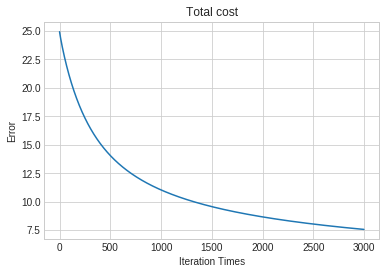

In [0]:
cutoff = 0.5
weights_bgd = logistic(training_dataset, cutoff, 3000, 0.08, gd='bgd', plot=True)

#### Validation- question 5(d)

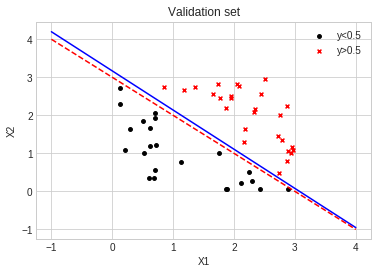

Error Classification Number: 0 / 50

Percentage:  0.0


In [0]:
error_count = model_predict(validation_dataset, weights_bgd, cutoff, plot_name="Validation set")
print('Error Classification Number: %s / %s\n' %(error_count, validation_dataset.shape[0]))
print("Percentage: ", error_count/validation_dataset.shape[0]*100)

Note: blue solid line is derived from batch gradient descent, red dash line is designed parameters used as I sample the data.

#### Stochastic Gradient Descent- question 5(b)

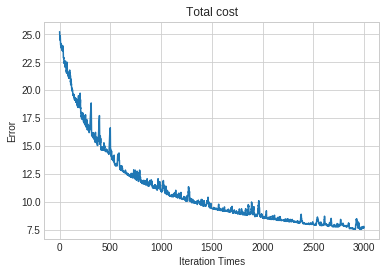

In [0]:
cutoff=0.5
weights_sgd = logistic(training_dataset, cutoff, 3000, 0.08, gd='sgd', plot=True)

#### Validation- question 5(d)

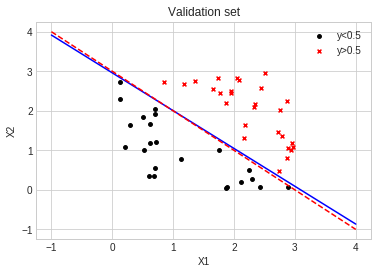

Error Classification Number: 0 / 50

Percentage:  0.0


In [0]:
error_count = model_predict(validation_dataset, weights_sgd, cutoff, plot_name="Validation set")
print('Error Classification Number: %s / %s\n' %(error_count, validation_dataset.shape[0]))
print("Percentage: ", error_count/validation_dataset.shape[0]*100)

Note: blue solid line is derived from batch gradient descent, red dash line is designed parameters used as I sample the data.

#### LDA classifier with Uniform Distribution predictors- question 5(c)(d)

[array([0.81669894, 1.29027014]), array([1.89248246, 2.20703738])]


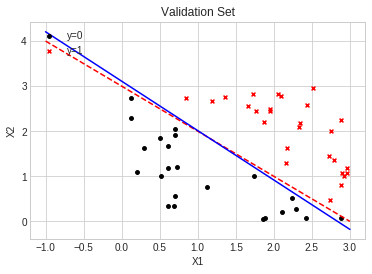

Error Classification Number: 1 / 50

Percentage:  2.0


In [0]:
class_num = 2
cutoff = 0.5
df_train = pd.DataFrame(np.zeros((SampleNum,1)), columns=["Category"])
df_train["Category"][training_dataset.labels<cutoff] = 0
df_train["Category"][training_dataset.labels>=cutoff] = 1
X_train = training_dataset.drop(['Inter', 'labels'], axis=1).values
y_train = df_train.Category.values

mean_vectors = []
for clas in range(0,class_num):
    mean_vectors.append(np.mean(X_train[y_train==clas], axis=0))
cov_matrix = np.cov(X_train[:,0], X_train[:,1])
error_count = LDA_classifier(mean_vectors, cov_matrix, validation_dataset, cutoff, 'Validation Set')
print('Error Classification Number: %s / %s\n' %(error_count, validation_dataset.shape[0]))
print("Percentage: ", error_count/validation_dataset.shape[0]*100)

Note: blue solid line is derived from batch gradient descent, red dash line is designed parameters used as I sample the data.

#### LDA classifier with Normal Distribution predictors- extra comparision

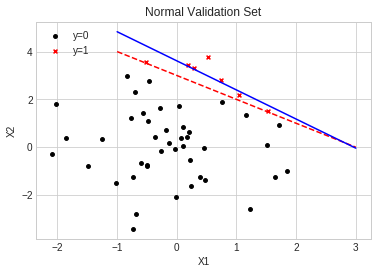

Error Classification Number: 3 / 50

Percentage:  6.0


In [0]:
SampleNum = 50
NumberOfPredictor = 2
Coefficients = np.array([-3, 1, 1])
Method = 'MultiNormal'
nor_training_dataset = Create_dataset(NumberOfPredictor, Coefficients, SampleNum, Method, '0', '1', '1', '2')
nor_validation_dataset = Create_dataset(NumberOfPredictor, Coefficients, SampleNum, Method, '0', '1', '1', '2')

cutoff = 0.5
df_train_nor = pd.DataFrame(np.zeros((SampleNum,1)), columns=["Category"])
df_train_nor["Category"][nor_training_dataset.labels<cutoff] = 0
df_train_nor["Category"][nor_training_dataset.labels>=cutoff] = 1

X_train_nor = nor_training_dataset.drop(['Inter', 'labels'], axis=1).values
y_train_nor = df_train_nor.Category.values

mean_vectors = []
for clas in range(0,class_num):
    mean_vectors.append(np.mean(X_train_nor[y_train_nor==clas], axis=0))
cov_matrix = np.cov(X_train_nor[:,0], X_train_nor[:,1])
error_count = LDA_classifier(mean_vectors, cov_matrix, nor_validation_dataset, cutoff, 'Normal Validation Set')
print('Error Classification Number: %s / %s\n' %(error_count, nor_validation_dataset.shape[0]))
print("Percentage: ", error_count/nor_validation_dataset.shape[0]*100)

Note: blue solid line is derived from batch gradient descent, red dash line is designed parameters used as I sample the data.

#### Fisher's LDA dimension reduction- extra comparison

#### Training set

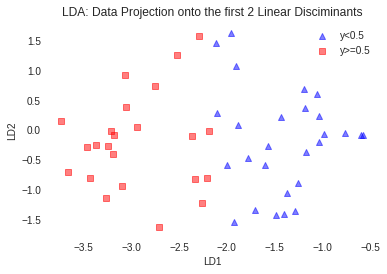

In [0]:
class_num = 2
cutoff = 0.5
df_train = pd.DataFrame(np.zeros((SampleNum,1)), columns=["Category"])
df_train["Category"][training_dataset.labels<cutoff] = 0
df_train["Category"][training_dataset.labels>=cutoff] = 1
X_train = training_dataset.drop(['Inter', 'labels'], axis=1).values
y_train = df_train.Category.values

W, mean_vectors = Fisher_LDA(X_train, y_train)
X_lda = X_train.dot(W)
assert X_lda.shape == (50,2), "The matrix is not 50x2 dimensional."
label_dict = {0: 'y<0.5', 1: 'y>=0.5'}
a = plot_step_lda(X_lda, y_train, label_dict)

#### Validation set

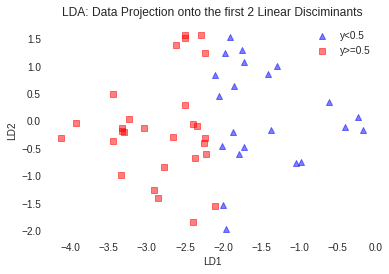

In [0]:
class_num = 2
cutoff = 0.5
df_val = pd.DataFrame(np.zeros((SampleNum,1)), columns=["Category"])
df_val["Category"][validation_dataset.labels<cutoff] = 0
df_val["Category"][validation_dataset.labels>=cutoff] = 1
X_val = validation_dataset.drop(['Inter', 'labels'], axis=1).values
y_val = df_val.Category.values

X_lda_val = X_val.dot(W)
assert X_lda_val.shape == (50,2), "The matrix is not 50x2 dimensional."
label_dict = {0: 'y<0.5', 1: 'y>=0.5'}
a = plot_step_lda(X_lda_val, y_val, label_dict)

#### Repeated 200 times- question 5(e)

In [0]:
iter_times = 200
SampleNum = 50
NumberOfPredictor = 2
Coefficients = np.array([-3, 1, 1])
cutoff = 0.5
class_num = 2
error_bgd = []
error_sgd = []
error_LDA = []

for iterr in range(iter_times):
    training_dataset = Create_dataset(NumberOfPredictor, Coefficients, SampleNum, Method='Uniform')
    validation_dataset = Create_dataset(NumberOfPredictor, Coefficients, SampleNum, Method='Uniform')
    weights_bgd = logistic(training_dataset, cutoff, 1000, 0.08, gd='bgd', plot=False)
    weights_sgd = logistic(training_dataset, cutoff, 1000, 0.08, gd='sgd', plot=False)
    error_count_bgd = model_predict(validation_dataset, weights_bgd, cutoff)
    error_count_sgd = model_predict(validation_dataset, weights_sgd, cutoff)
    error_bgd.append(error_count_bgd)
    error_sgd.append(error_count_sgd)
    
    df_train = pd.DataFrame(np.zeros((SampleNum,1)), columns=["Category"])
    df_train["Category"][training_dataset.labels<cutoff] = 0
    df_train["Category"][training_dataset.labels>=cutoff] = 1
    X_train = training_dataset.drop(['Inter', 'labels'], axis=1).values
    y_train = df_train.Category.values
    
    mean_vectors = []
    for clas in range(0,class_num):
        mean_vectors.append(np.mean(X_train[y_train==clas], axis=0))
    cov_matrix = np.cov(X_train[:,0], X_train[:,1])
    error_count_LDA = LDA_classifier(mean_vectors, cov_matrix, validation_dataset, cutoff)
    error_LDA.append(error_count_LDA)

Text(0.5, 1.0, 'LDA with same Covariacne Matrix')

<Figure size 432x288 with 0 Axes>

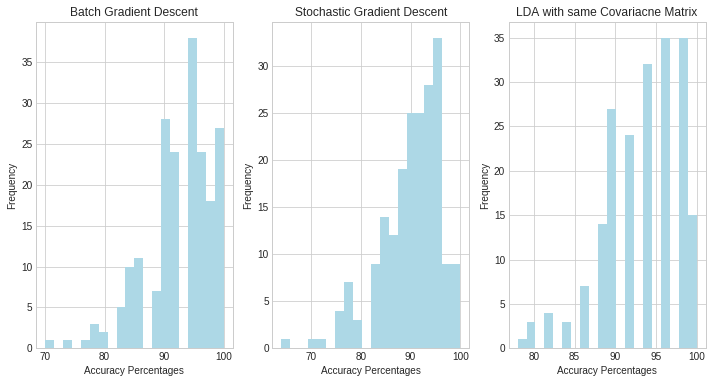

In [0]:
fig = plt.figure()
plt.figure(figsize=(12,6))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
plt.subplot(1, 3, 1)
plt.hist(100-np.array(error_bgd)/validation_dataset.shape[0]*100, bins=20, color="lightblue")
plt.xlabel("Accuracy Percentages")
plt.ylabel("Frequency")
plt.title("Batch Gradient Descent")

plt.subplot(1, 3, 2)
plt.hist(100-np.array(error_sgd)/validation_dataset.shape[0]*100, bins=20, color="lightblue")
plt.xlabel("Accuracy Percentages")
plt.ylabel("Frequency")
plt.title("Stochastic Gradient Descent")

plt.subplot(1, 3, 3)
plt.hist(100-np.array(error_LDA)/validation_dataset.shape[0]*100, bins=20, color="lightblue")
plt.xlabel("Accuracy Percentages")
plt.ylabel("Frequency")
plt.title("LDA with same Covariacne Matrix")

### Interpretation:
(1) In this section, the interation times per training is 1000 for each gradient descent practice. In problem 5(e), we can see that the performance of batch gradient descent and stochastic gradient descent are good. Actually, as we use interation=3000, we can get a more precise model compared with the result shown above, even though in validation set.

(2) Batch gradient descent has a little bit better results than stochastic gradient descent.

(3) Furthermore, as I use Linear Discriminant Analysis as a classifier, I got a really good performance in both training and validation datasets. As we can see, in different created datasets and models in different iteration, the mean and variation of accuracy percentage are pretty small and concentrated between 90~100%.

(4) According to the hypothesis, the predictors follow Normal Distribution, I made predictors following X1~N(0,1) and X2~N(1,2) to test the performance under correct assumption. The result is shown in the second part of problem 5(c)(d) above. In summary, if predictors follow Normal Distribution, LDA classifier does work, but I think LDA is not limited in using Normal Distribution only (as the result shown in problem 5(e)).

(5) By the way, I also made Fisher's LDA (dimension reduction) model. In this case, I find that because Fisher's model doesn't make the assumption which forces predictors following Normal Distribution, we can obtain a good performance with the visualiztion engineering to "separate" two classes. 